# Developer Notebook
A notebook for developing functions in the main project

## Imports

In [28]:
from transformers import pipeline
import datetime
import pandas as pd
import numpy as np
import plotly.express as px

from services.alpaca_api_client import Alpaca_APIClient, get_alpaca_client
from config.api_settings import Alpaca_APIConfig


## Alpaca News Sentiment Analysis Function for a list of tickers

In [16]:
alpaca_api = get_alpaca_client(Alpaca_APIConfig.get_alpaca_api_key, Alpaca_APIConfig.get_alpaca_secret_key)
pipe = pipeline("text-classification", model="ProsusAI/finbert")

Device set to use mps:0


In [18]:
# Function to extract titles
def extract_titles(news_list):
    return [news['headline'] for news in news_list]

In [100]:
tickers = ['AAPL', 'NVDA', 'GOOGL']

dt_start = datetime.datetime(2024, 1, 3, 0, 0, 0)
dt_end = datetime.datetime(2025, 3, 3, 0, 0, 0)
combined_df = pd.DataFrame()
aggregated_sentiment_list = []

for ticker in tickers:
    alpaca_news = alpaca_api.get_news(ticker, alpaca_api.get_alpaca_datetime(dt_start), alpaca_api.get_alpaca_datetime(dt_end), limit=20)

    if alpaca_news is not None:
        news = alpaca_news
    else:
        news = []

    # Example news sentiment outputs
    titles = extract_titles(news)
    news_sentiments = pipe(titles) if titles else []

    # Count the occurrences of each sentiment label
    sentiment_counts = {'positive': 0, 'neutral': 0, 'negative': 0}
    for sentiment in news_sentiments: # pyright: ignore
        sentiment_counts[sentiment['label']] += 1 # pyright: ignore

    list_items = list(sentiment_counts.items())
    df = pd.DataFrame(list_items, columns=['Sentiment', 'Count']) # pyright: ignore

    df['ticker'] = ticker # Add column to identify ticker
    combined_df = pd.concat([combined_df, df])

    # Mapping sentiment labels to numerical values
    sentiment_map = {'positive': 1, 'neutral': 0, 'negative': -1}

    # Weighted average of sentiment scores
    weighted_scores = np.array([sentiment_map[item['label']] * item['score'] for item in news_sentiments]) # pyright: ignore
    average_score = np.sum(weighted_scores) / np.sum([item['score'] for item in news_sentiments]) # pyright: ignore

    # Determine the aggregated sentiment label
    aggregated_sentiment = "positive" if average_score > 0 else "negative" if average_score < 0 else "neutral"

    aggregated_sentiment_list.append((ticker, aggregated_sentiment))

aggregated_sentiment_df = pd.DataFrame(aggregated_sentiment_list, columns=['ticker','average_sentiment'])
combined_df = combined_df.reset_index(drop=True)
combined_df

,Sentiment,Count,ticker
0,positive,2,AAPL
1,neutral,10,AAPL
2,negative,8,AAPL
3,positive,3,NVDA
4,neutral,9,NVDA
5,negative,8,NVDA
6,positive,5,GOOGL
7,neutral,8,GOOGL
8,negative,7,GOOGL


In [102]:
aggregated_sentiment_df

,ticker,average_sentiment
0,AAPL,negative
1,NVDA,negative
2,GOOGL,negative


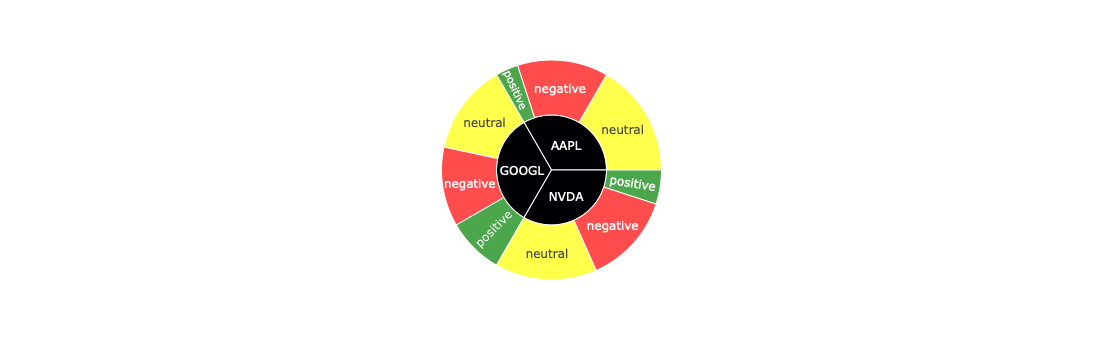

In [92]:
# Custom color palette
color_map = {
    'positive': 'green',  
    'neutral': 'yellow',   
    'negative': 'red'   
}

fig = px.sunburst(
    combined_df, 
    names='ticker',
    path=['ticker', 'Sentiment'], 
    values='Count',
    color='Sentiment',  # Assign colors based on Sentiment
    color_discrete_map=color_map  # Custom color map
)

fig.show()